**Important Libraries**

In [3]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import VGG16,VGG19,ResNet50,DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils


**Incorporate google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load Data ,split-them**

In [4]:
import os
import random
from sklearn.model_selection import train_test_split

# Path to the original dataset
data_dir = '/content/drive/MyDrive/mpox-1-binary/dataset/Augmented Images/Augmented Images'
all_images = []
labels = []

# Load all image paths and corresponding labels
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

# Split data into 75% train, 15% validation, and 10% test
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, labels, test_size=0.25, stratify=labels, random_state=42
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.4, stratify=temp_labels, random_state=42
)
total_images = len(all_images)
print(f"Total number of images: {total_images}")

# You can also print the number of images per class if needed
from collections import Counter
class_counts = Counter(labels)
print("Number of images per class:", class_counts)

Total number of images: 3192
Number of images per class: Counter({'Others_augmented': 1764, 'Monkeypox_augmented': 1428})


**PieChart-class-percentage**

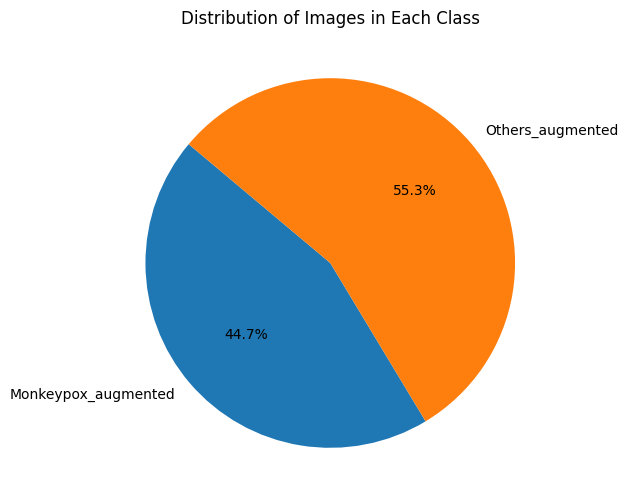

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of images per class
class_counts = Counter(labels)

# Extract class names and corresponding counts
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Images in Each Class")
plt.show()


**class-wise-images in each split**

In [6]:
from collections import Counter

# Count the images per class in each split
train_class_counts = Counter(train_labels)
val_class_counts = Counter(val_labels)
test_class_counts = Counter(test_labels)

# Print the counts for each split
print(f"Total number of images: {total_images}")
print("Number of images per class (entire dataset):", class_counts)
print("Number of images per class in training set:", train_class_counts)
print("Number of images per class in validation set:", val_class_counts)
print("Number of images per class in test set:", test_class_counts)

Total number of images: 3192
Number of images per class (entire dataset): Counter({'Others_augmented': 1764, 'Monkeypox_augmented': 1428})
Number of images per class in training set: Counter({'Others_augmented': 1323, 'Monkeypox_augmented': 1071})
Number of images per class in validation set: Counter({'Others_augmented': 264, 'Monkeypox_augmented': 214})
Number of images per class in test set: Counter({'Others_augmented': 177, 'Monkeypox_augmented': 143})


**Barchart**

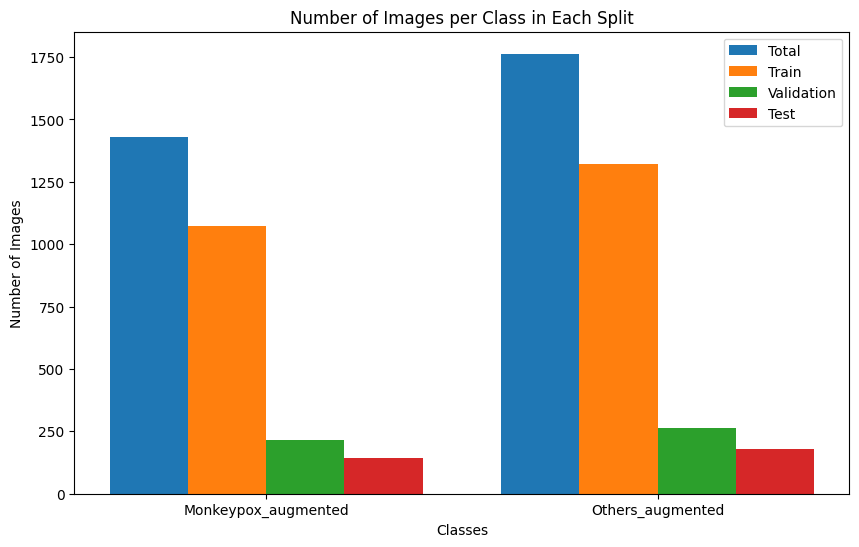

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Count the images per class in each split
train_class_counts = Counter(train_labels)
val_class_counts = Counter(val_labels)
test_class_counts = Counter(test_labels)

# Classes and counts for each split
classes = list(class_counts.keys())
total_counts = [class_counts[cls] for cls in classes]
train_counts = [train_class_counts[cls] for cls in classes]
val_counts = [val_class_counts[cls] for cls in classes]
test_counts = [test_class_counts[cls] for cls in classes]

# Plot grouped bar chart
x = np.arange(len(classes))  # Label locations
width = 0.2  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))
bars_total = ax.bar(x - width, total_counts, width, label='Total')
bars_train = ax.bar(x, train_counts, width, label='Train')
bars_val = ax.bar(x + width, val_counts, width, label='Validation')
bars_test = ax.bar(x + 2 * width, test_counts, width, label='Test')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel("Classes")
ax.set_ylabel("Number of Images")
ax.set_title("Number of Images per Class in Each Split")
ax.set_xticks(x + width / 2)
ax.set_xticklabels(classes)
ax.legend()

plt.show()


**Data Augmentation**

In [8]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for rescaling
data_gen = ImageDataGenerator(rescale=1./255)

# Create a function to generate data from lists
def create_generator(file_paths, labels, batch_size=16, shuffle=True):
    # Create a DataFrame with paths and labels
    data = pd.DataFrame({'filename': file_paths, 'class': labels})
    return data_gen.flow_from_dataframe(
        data,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle # Add shuffle parameter for flexibility
    )

# Create data generators
train_generator = create_generator(train_images, train_labels)
val_generator = create_generator(val_images, val_labels)
test_generator = create_generator(test_images, test_labels, batch_size=16, shuffle=False)



Found 2394 validated image filenames belonging to 2 classes.
Found 478 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.


**Checking indices**

In [9]:
print(train_generator.class_indices)
print(test_generator.class_indices)
print(val_generator.class_indices)

{'Monkeypox_augmented': 0, 'Others_augmented': 1}
{'Monkeypox_augmented': 0, 'Others_augmented': 1}
{'Monkeypox_augmented': 0, 'Others_augmented': 1}


**Visualize some samples**

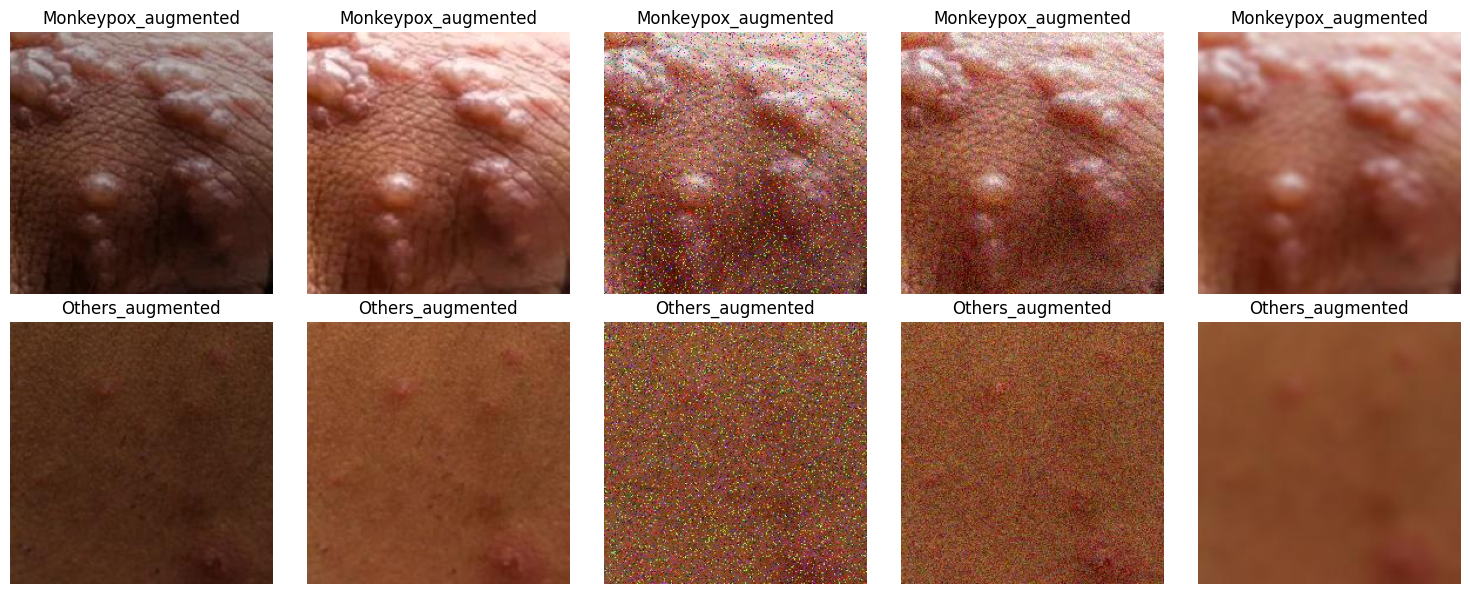

In [11]:
import matplotlib.pyplot as plt
import cv2
import random

# Function to display sample images
def show_sample_images(images, labels, num_samples=5):
    unique_classes = list(set(labels))
    samples_per_class = {cls: [] for cls in unique_classes}

    # Collect sample images for each class
    for img, label in zip(images, labels):
        if len(samples_per_class[label]) < num_samples:
            samples_per_class[label].append(img)

    # Plot the samples
    fig, axes = plt.subplots(len(unique_classes), num_samples, figsize=(15, 3 * len(unique_classes)))
    for i, (cls, img_paths) in enumerate(samples_per_class.items()):
        for j, img_path in enumerate(img_paths):
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

            ax = axes[i, j] if len(unique_classes) > 1 else axes[j]
            ax.imshow(image)
            ax.set_title(cls)
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images(all_images, labels, num_samples=5)


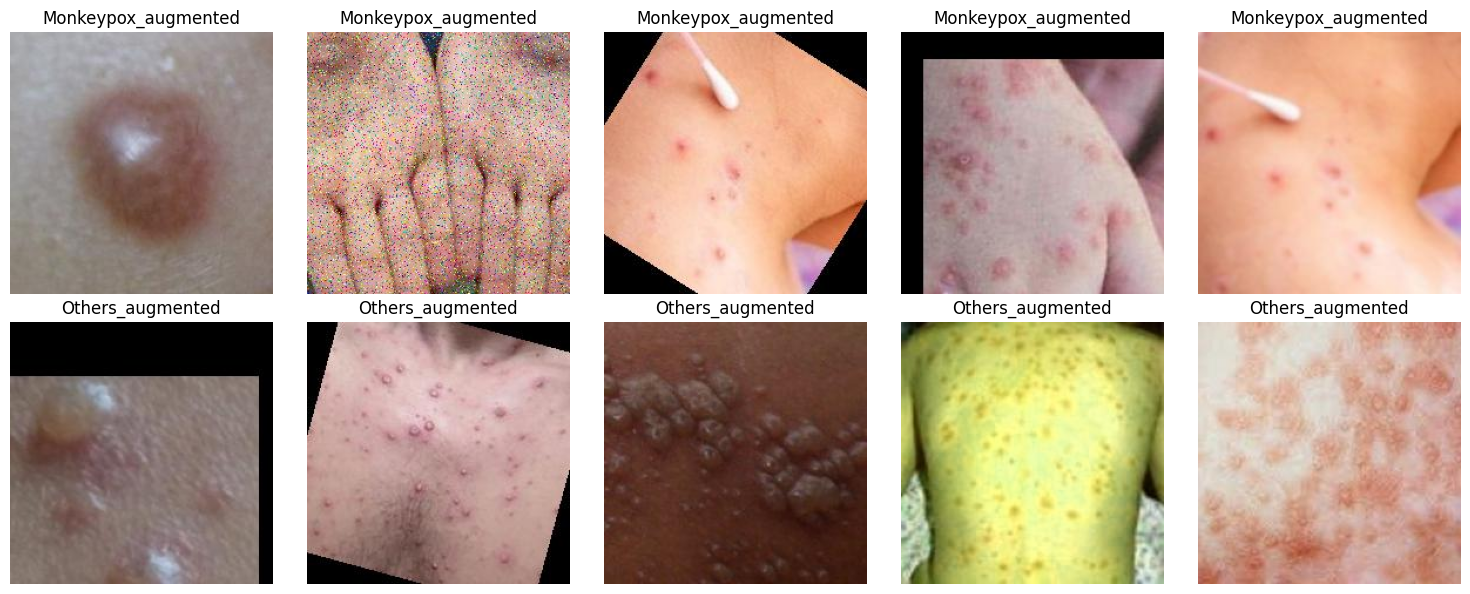

In [10]:
import matplotlib.pyplot as plt
import cv2
import random

# Function to display sample images
def show_sample_images(images, labels, num_samples=5):
    unique_classes = list(set(labels))
    samples_per_class = {cls: [] for cls in unique_classes}

    # Combine images and labels, then shuffle
    combined = list(zip(images, labels))
    random.shuffle(combined)

    # Collect sample images for each class
    for img, label in combined:
        if len(samples_per_class[label]) < num_samples:
            samples_per_class[label].append(img)

    # Ensure we have the required number of samples for each class
    for cls, img_paths in samples_per_class.items():
        if len(img_paths) < num_samples:
            print(f"Warning: Only found {len(img_paths)} images for class '{cls}'")

    # Plot the samples
    fig, axes = plt.subplots(len(unique_classes), num_samples, figsize=(15, 3 * len(unique_classes)))
    for i, (cls, img_paths) in enumerate(samples_per_class.items()):
        for j, img_path in enumerate(img_paths):
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

            ax = axes[i, j] if len(unique_classes) > 1 else axes[j]
            ax.imshow(image)
            ax.set_title(cls)
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images(all_images, labels, num_samples=5)


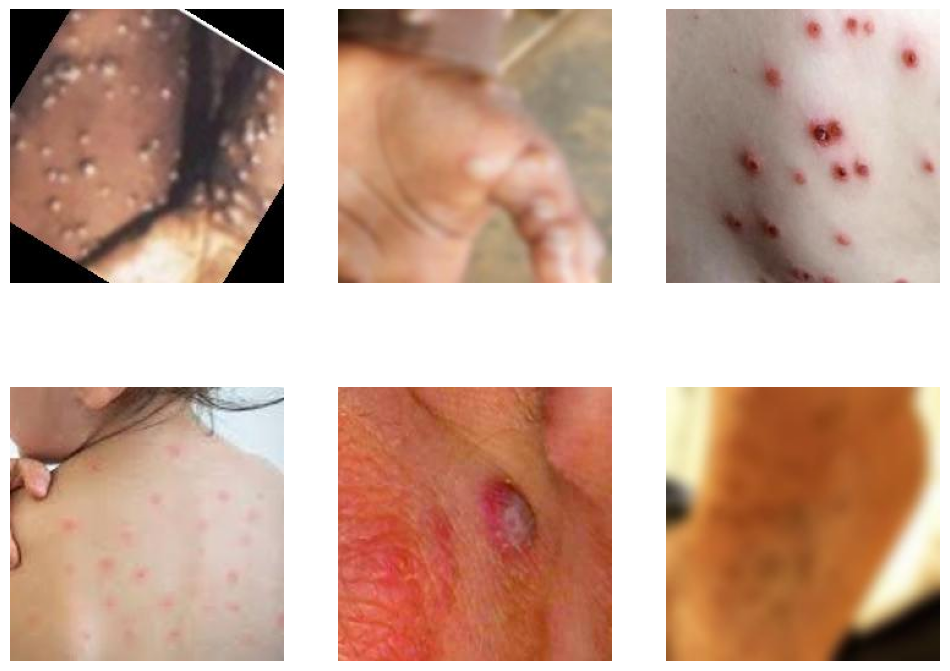

In [12]:
sample_x, sample_y = next(train_generator)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

**Model Build**

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16,InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pretrained VGG16 model and freeze its layers
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
    layer.trainable = False

# Add custom layers on top of the base model's output
x = model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

# Define the final model structure, starting from the original model's input
model = Model(inputs=model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 34,910,754 (133.17 MB)

 Trainable params: 13,107,970 (50.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

**Train parameter-settings**

In [14]:
#compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/mpox-1-binary/result-gmail/incetionv3/inceptionv3_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

**Training model**

In [15]:
%%time

#train the model
history = model.fit(train_generator,
                    epochs = 30,
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6861 - loss: 1.2182
Epoch 1: val_accuracy improved from -inf to 0.89121, saving model to /content/drive/MyDrive/mpox-1-binary/result-gmail/incetionv3/inceptionv3_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 665s 4s/step - accuracy: 0.6867 - loss: 1.2144 - val_accuracy: 0.8912 - val_loss: 0.2672 - learning_rate: 1.0000e-04
Epoch 2/30
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8839 - loss: 0.2792
Epoch 2: val_accuracy improved from 0.89121 to 0.91841, saving model to /content/drive/MyDrive/mpox-1-binary/result-gmail/incetionv3/inceptionv3_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.8840 - loss: 0.2790 - val_accuracy: 0.9184 - val_loss: 0.1998 - learning_rate: 1.0000e-04
Epoch 3/30
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9322 - loss: 0.1727
Epoch 3: val_accuracy improved from 0.91841 to 0.94142, saving model to /content/drive/MyDrive/mpox-1-binary/result-gmail/incetionv3/inceptionv3_mo

**Accuracy and loss curve**

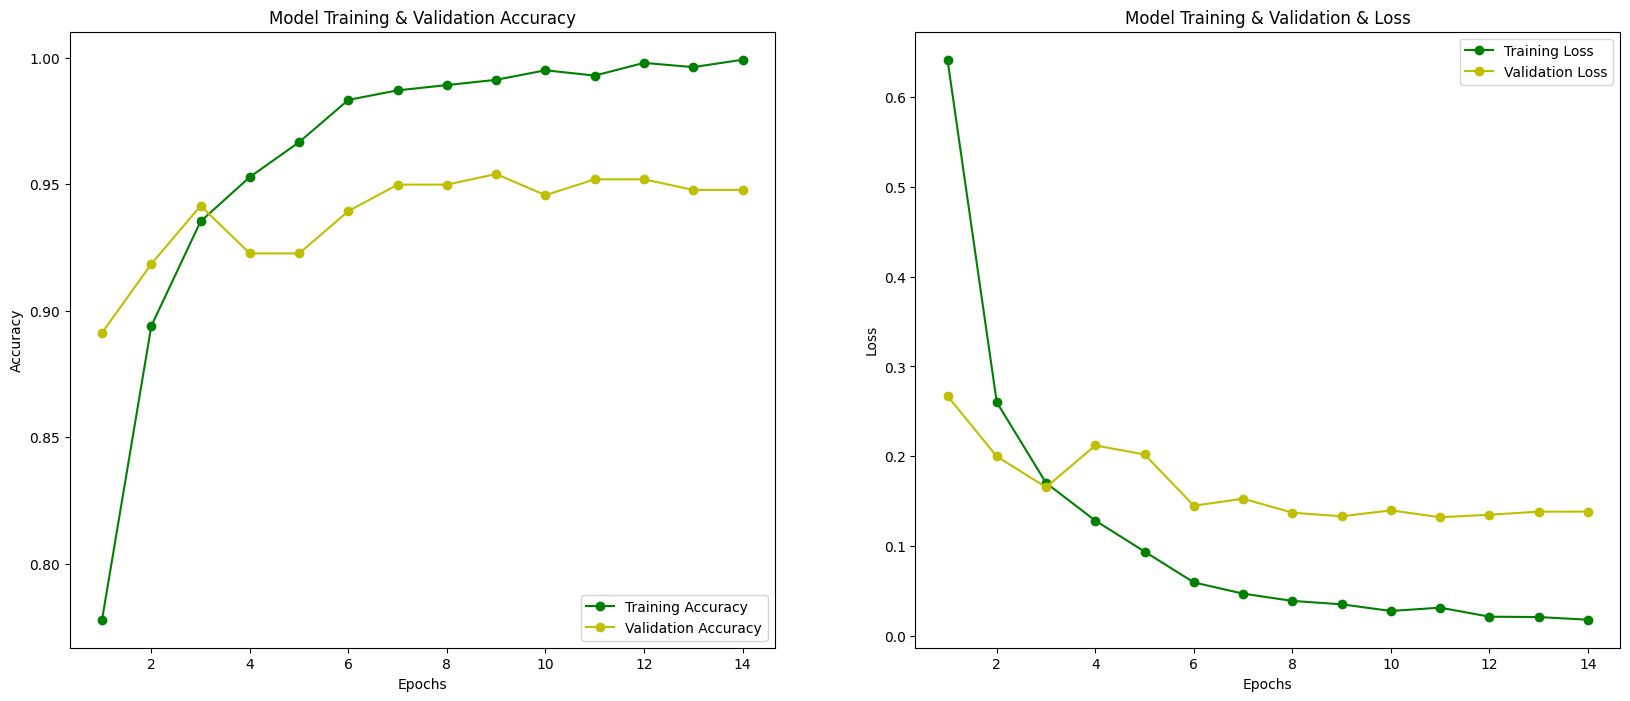

In [16]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

**Load Model**

In [ ]:
best_model_path = '/content/drive/MyDrive/mpox-1-binary/result-gmail/vgg16/vgg16_model.keras'
model.load_weights(best_model_path)

# Evaluate the loaded model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Best Model Test Accuracy: {test_accuracy:.2f}")
print(f"Best Model Test Loss: {test_loss:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8813 - loss: 0.2830
Best Model Test Accuracy: 0.88
Best Model Test Loss: 0.29


**Evaluate result**

In [17]:
print('Train accuracy & loss:', model.evaluate(train_generator))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_generator))

150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9998 - loss: 0.0076
Train accuracy & loss: [0.007339284755289555, 0.9995822906494141]


20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9553 - loss: 0.0993
Test accuracy & loss: [0.11319766193628311, 0.949999988079071]


**Get the test and predicted results**

In [18]:
y_test = test_generator.classes

#make prediction
yhat_test = np.argmax(model.predict(test_generator), axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step


**Confusion matrix settings**

In [19]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

**Plot confusion matrix**

[[131  12]
 [  4 173]]


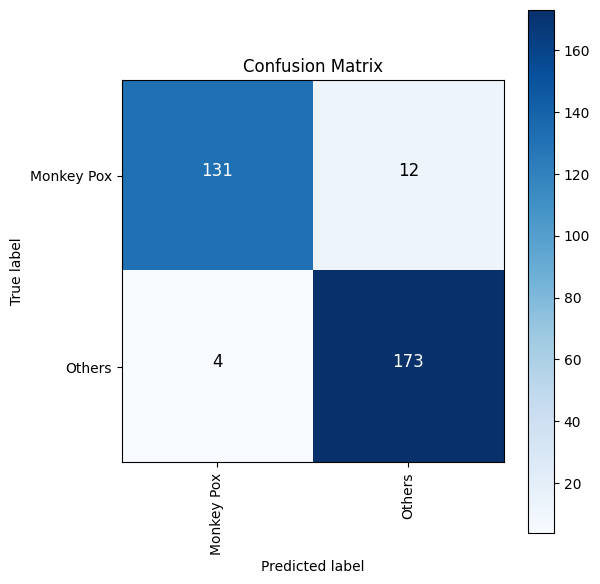

In [20]:
#get confusion matrix
classes = os.listdir('/content/drive/MyDrive/mpox-1-binary/dataset/Original Images/Original Images')
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

**classification report**

In [21]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       143
           1       0.94      0.98      0.96       177

    accuracy                           0.95       320
   macro avg       0.95      0.95      0.95       320
weighted avg       0.95      0.95      0.95       320



**prediction parameters**

In [22]:
import PIL
import numpy as np
from sklearn.metrics import accuracy_score

class_dict = {0: 'Monkeypox_augmented', 1: 'Others_augmented'}
label_mapping = {'Monkeypox_augmented': 0, 'Others_augmented': 1}
img_width, img_height = 224, 224
prediction = []
original = []
image = []

# Assuming test_images and test_labels are correctly defined
for img_path, label in zip(test_images, test_labels):
    try:
        # Load and preprocess the image
        img = PIL.Image.open(img_path).convert('RGB')  # Convert to RGB if needed
        img = img.resize((img_width, img_height))  # Resize to match model input
        img = np.expand_dims(np.array(img), axis=0)  # Convert to NumPy and add batch dimension
        img = img / 255.0  # Normalize if the model expects scaled inputs
        image.append(PIL.Image.open(img_path))  # Append original image for visualization

        # Predict the class
        predict = model.predict(img)
        predict_class = np.argmax(predict)
        prediction.append(class_dict[predict_class])

        # Convert the label to numerical class and store
        original.append(class_dict[label_mapping.get(label, 1)])
    except Exception as e:
        print(f"Error processing image {img_path} with label {label}: {e}")

# Confirm that the lists have been populated
print(f"Number of images: {len(image)}")
print(f"Number of predictions: {len(prediction)}")
print(f"Number of originals: {len(original)}")

# If predictions and originals are populated, calculate accuracy
if len(prediction) == len(original) == len(image):
    score = accuracy_score(original, prediction)
    print("Test Accuracy: {:.2f}%".format(score * 100))
else:
    print("Prediction and original labels mismatch.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

**check test accuacy**

In [23]:
#test accuracy
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.95


In [24]:
print(f"Number of images: {len(image)}")
print(f"Number of predictions: {len(prediction)}")
print(f"Number of originals: {len(original)}")


Number of images: 320
Number of predictions: 320
Number of originals: 320


**check models prediction result**

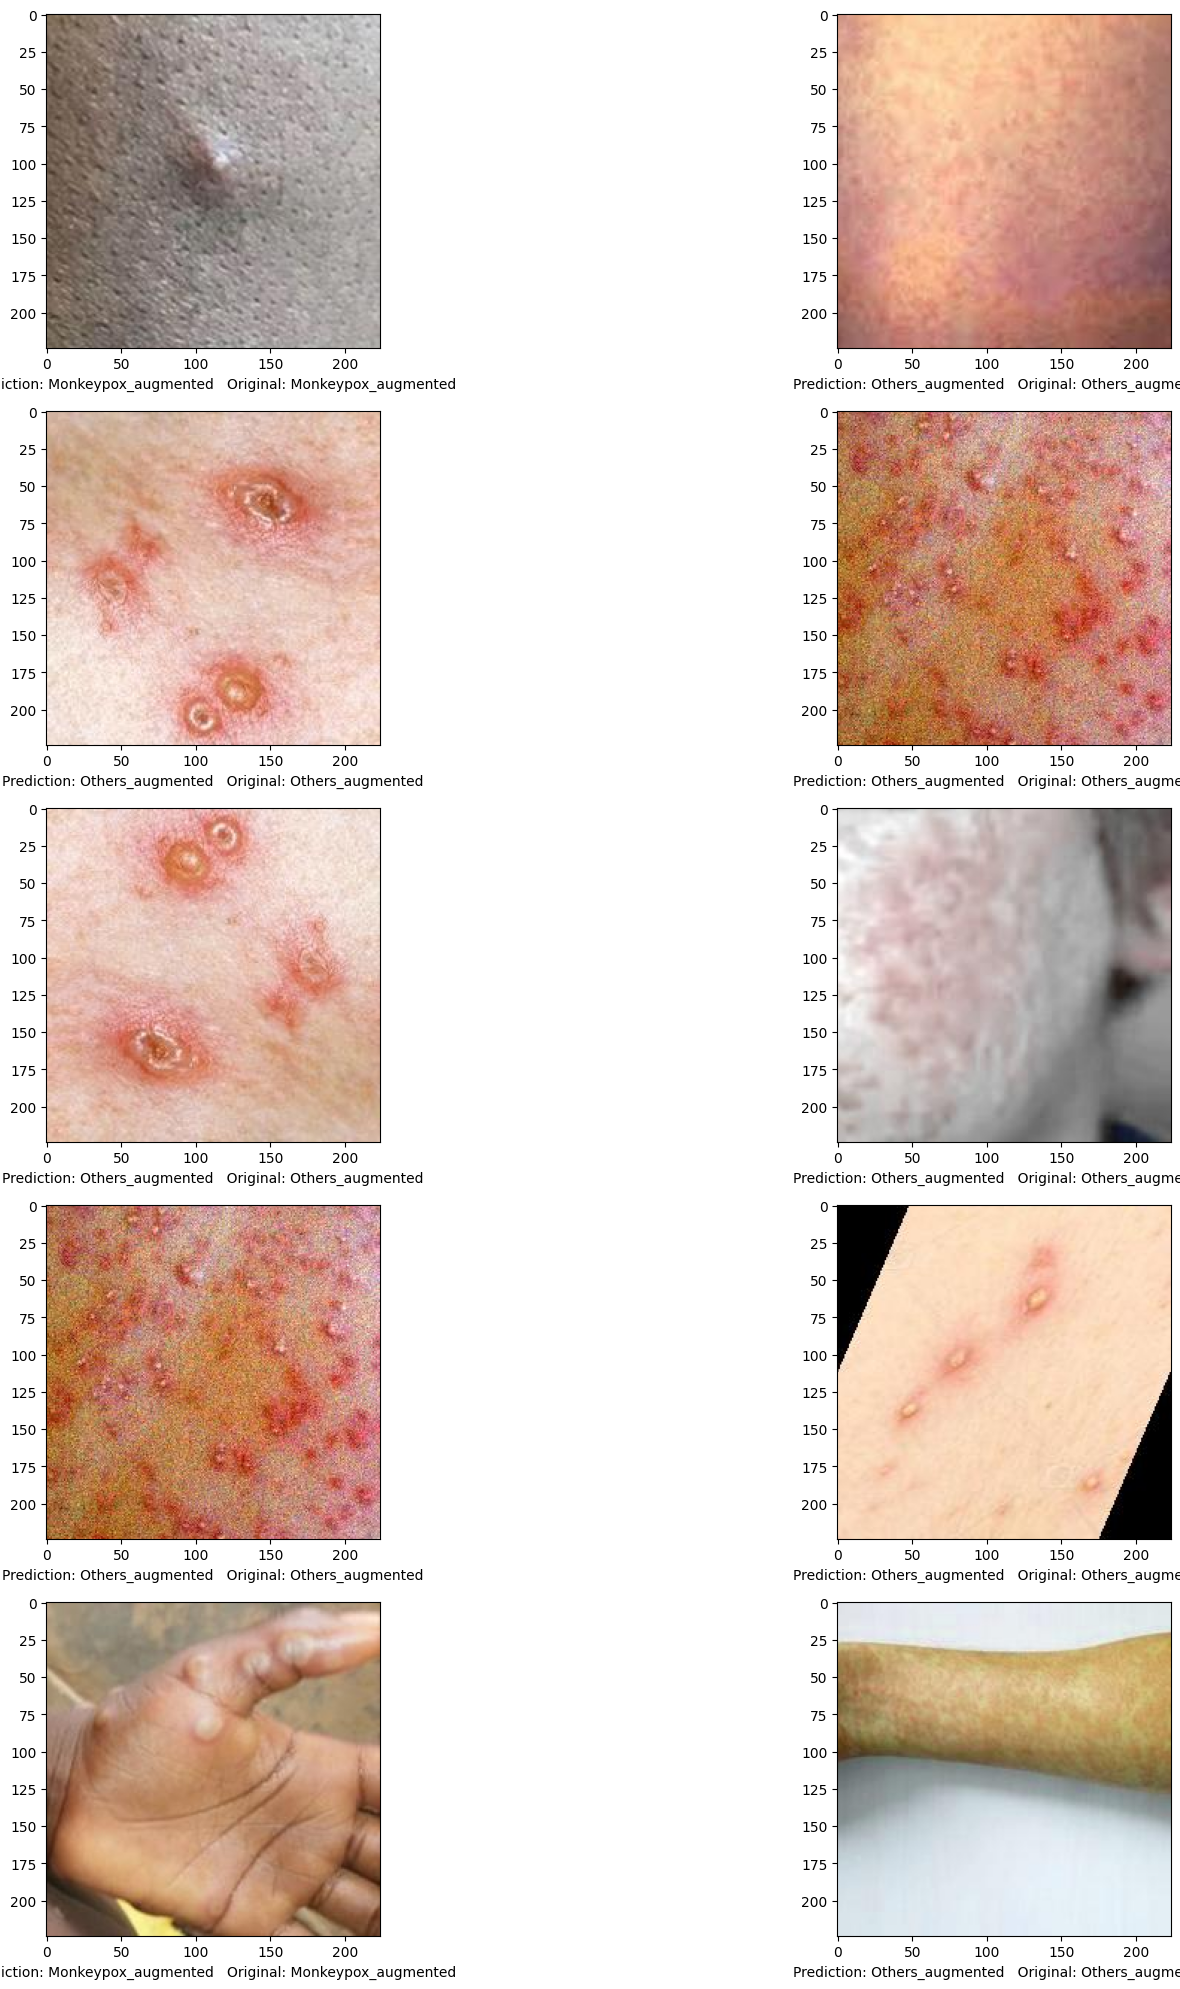

In [25]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(20, 20))
for i in range(10):
    j = random.randint(0, len(image) - 1)  # Change here to prevent out-of-range index
    fig.add_subplot(5, 2, i + 1)
    plt.xlabel("Prediction: " + prediction[j] + "   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()


**Show Confusion matrix,ROC curve**

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


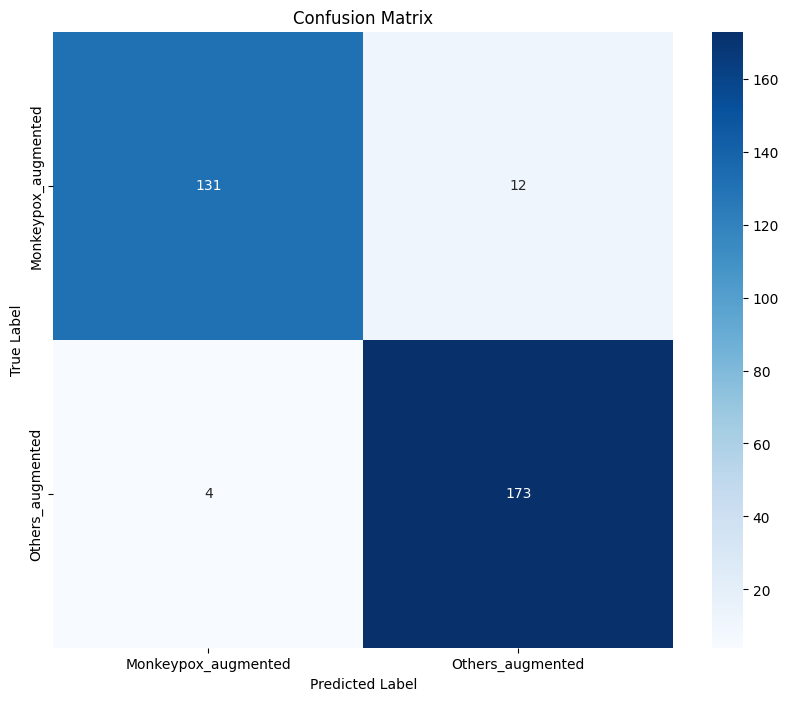

Classification Report:
                      precision    recall  f1-score   support

Monkeypox_augmented       0.97      0.92      0.94       143
   Others_augmented       0.94      0.98      0.96       177

           accuracy                           0.95       320
          macro avg       0.95      0.95      0.95       320
       weighted avg       0.95      0.95      0.95       320

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


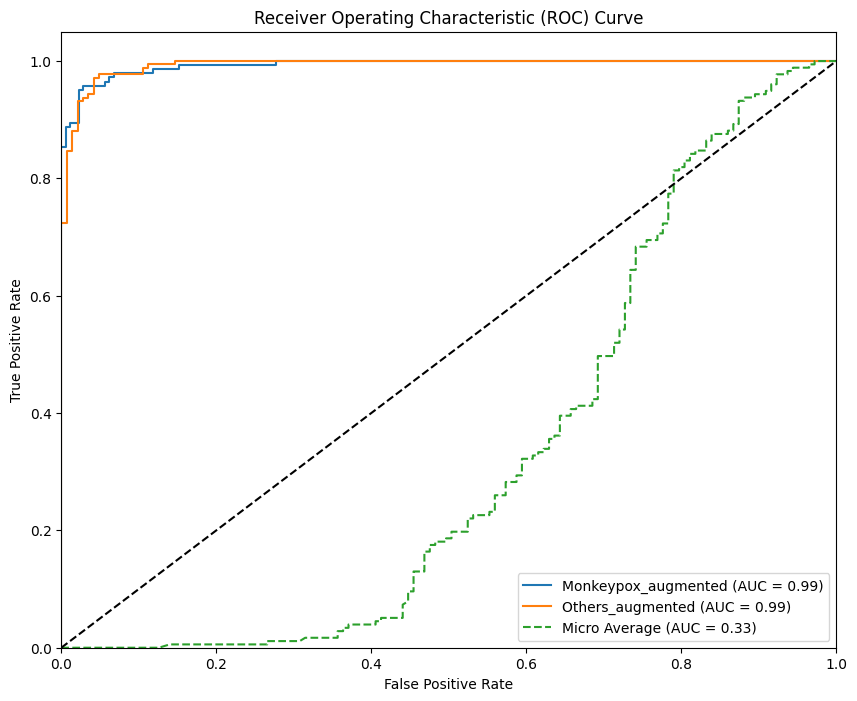

In [30]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Make Predictions
val_generator.reset()  # Reset the generator if it's used previously in training
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# True labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Step 2: Generate the Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 3: Generate a Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:\n', report)

# Step 4: Generate ROC Curve
# Get the predicted probabilities for each class
predicted_probabilities = model.predict(test_generator)

# Initialize a figure for the ROC curves
plt.figure(figsize=(10, 8))

# Calculate and plot the ROC curve for each class
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(true_classes, predicted_probabilities[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# Plot the ROC curve for the micro average
fpr_micro, tpr_micro, _ = roc_curve(true_classes, np.max(predicted_probabilities, axis=1), pos_label=1)
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, label=f'Micro Average (AUC = {roc_auc_micro:.2f})', linestyle='--')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


**GRAD CAM -Explainable AI**
**--Red means these regions are the most imported portion for prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


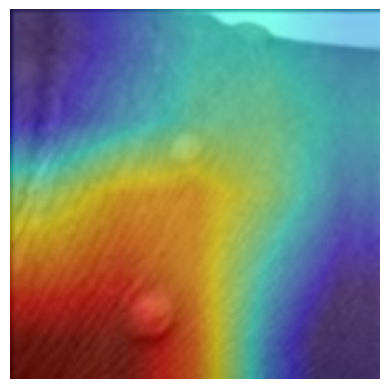

In [27]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """
    Visualizes Grad-CAM heatmap overlaid on the original image.

    Parameters:
    model (tf.keras.Model): Compiled model with weights loaded.
    image (array): Image to perform inference on.
    interpolant (float): Interpolation weight for heatmap overlay.
    plot_results (bool): Whether to plot the results or return heatmap.

    Returns:
    If plot_results is False, returns the heatmap.
    """
    # Sanity check for interpolant
    assert 0 < interpolant < 1, "Heatmap Interpolation Must Be Between 0 and 1"

    # STEP 1: Preprocess the image and make predictions
    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)  # Add batch dimension
    prediction = model.predict(img)             # Model prediction
    prediction_idx = np.argmax(prediction)      # Predicted class index

    # STEP 2: Identify the last convolutional layer
    last_conv_layer = next(
        (x for x in model.layers[::-1] if isinstance(x, (tf.keras.layers.Conv2D, tf.keras.layers.Conv2DTranspose))),
        None
    )

    if last_conv_layer is None:
        raise ValueError("No convolutional layers found in the model.")

    target_layer = model.get_layer(last_conv_layer.name)

    # Compute gradient of the top predicted class
    with tf.GradientTape() as tape:
        # Create a model with original model inputs and last conv layer as output
        gradient_model = Model(inputs=[model.inputs], outputs=[target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]  # Prediction loss for the target class

    # Calculate gradients of the target class prediction w.r.t. the last conv layer
    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]  # Shape [H x W x Channels]

    # Compute weights using the mean of the gradients
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # STEP 3: Create the activation map
    activation_map = np.zeros(output.shape[:2], dtype=np.float32)

    # Weight each channel in the output feature map
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to original image size and normalize
    activation_map = cv2.resize(activation_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)  # Ensure no negatives
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)  # Convert to 0-255 scale

    # Convert to heatmap and apply color map
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    heatmap_array = img_to_array(heatmap)

    # Superimpose the heatmap onto the original image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    combined_img = np.uint8(original_img * interpolant + heatmap_array * (1 - interpolant))

    # Display or return results
    if plot_results:
        plt.imshow(combined_img)
        plt.axis('off')
        plt.show()
    else:
        return heatmap_array

# Now using the function
test_img_batch, test_label_batch = next(test_generator)

# Select the first image from the batch
test_img = test_img_batch[0]

# Apply the Grad-CAM visualization function
VizGradCAM(model, test_img, plot_results=True)


**GradCam result side-side**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


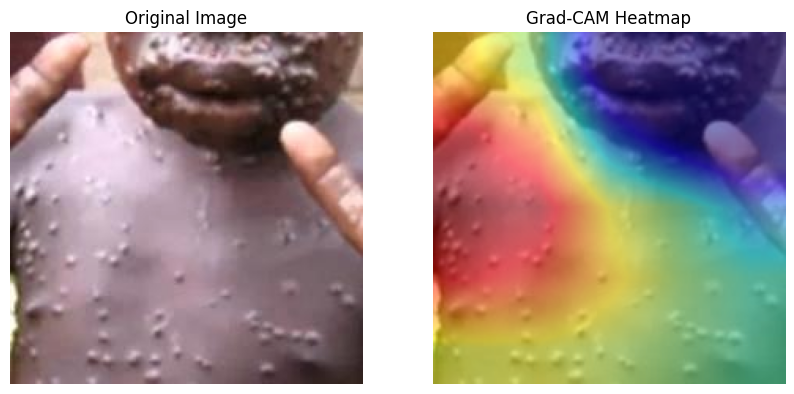

In [31]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """
    Visualizes Grad-CAM heatmap overlaid on the original image.

    Parameters:
    model (tf.keras.Model): Compiled model with weights loaded.
    image (array): Image to perform inference on.
    interpolant (float): Interpolation weight for heatmap overlay.
    plot_results (bool): Whether to plot the results or return heatmap.

    Returns:
    If plot_results is False, returns the heatmap and the original image.
    """
    # Sanity check for interpolant
    assert 0 < interpolant < 1, "Heatmap Interpolation Must Be Between 0 and 1"

    # STEP 1: Preprocess the image and make predictions
    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)  # Add batch dimension
    prediction = model.predict(img)             # Model prediction
    prediction_idx = np.argmax(prediction)      # Predicted class index

    # STEP 2: Identify the last convolutional layer
    last_conv_layer = next(
        (x for x in model.layers[::-1] if isinstance(x, (tf.keras.layers.Conv2D, tf.keras.layers.Conv2DTranspose))),
        None
    )

    if last_conv_layer is None:
        raise ValueError("No convolutional layers found in the model.")

    target_layer = model.get_layer(last_conv_layer.name)

    # Compute gradient of the top predicted class
    with tf.GradientTape() as tape:
        # Create a model with original model inputs and last conv layer as output
        gradient_model = Model(inputs=[model.inputs], outputs=[target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]  # Prediction loss for the target class

    # Calculate gradients of the target class prediction w.r.t. the last conv layer
    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]  # Shape [H x W x Channels]

    # Compute weights using the mean of the gradients
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # STEP 3: Create the activation map
    activation_map = np.zeros(output.shape[:2], dtype=np.float32)

    # Weight each channel in the output feature map
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to original image size and normalize
    activation_map = cv2.resize(activation_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)  # Ensure no negatives
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)  # Convert to 0-255 scale

    # Convert to heatmap and apply color map
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    heatmap_array = img_to_array(heatmap)

    # Superimpose the heatmap onto the original image
    original_img_normalized = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    combined_img = np.uint8(original_img_normalized * interpolant + heatmap_array * (1 - interpolant))

    # Display or return results
    if plot_results:
        # Plot the original and Grad-CAM images side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original_img_normalized.astype(np.uint8))
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(combined_img)
        axes[1].set_title("Grad-CAM Heatmap")
        axes[1].axis("off")

        plt.show()
    else:
        return heatmap_array, original_img_normalized

# Now using the function
test_img_batch, test_label_batch = next(test_generator)

# Select the first image from the batch
test_img = test_img_batch[0]

# Apply the Grad-CAM visualization function
VizGradCAM(model, test_img, plot_results=True)


**GradCam result side-side**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


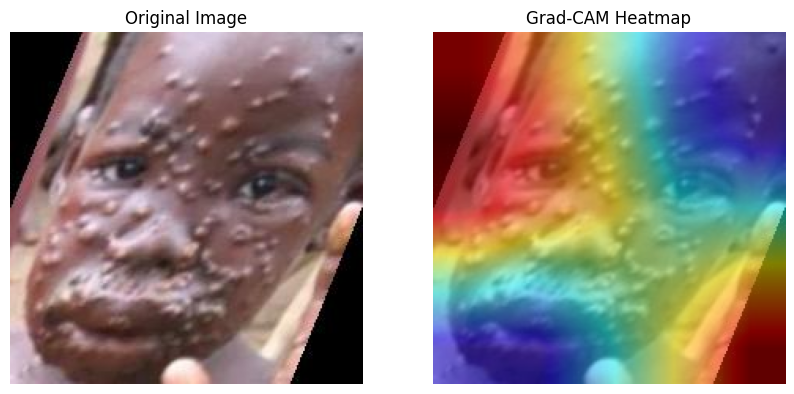

In [37]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """
    Visualizes Grad-CAM heatmap overlaid on the original image.

    Parameters:
    model (tf.keras.Model): Compiled model with weights loaded.
    image (array): Image to perform inference on.
    interpolant (float): Interpolation weight for heatmap overlay.
    plot_results (bool): Whether to plot the results or return heatmap.

    Returns:
    If plot_results is False, returns the heatmap and the original image.
    """
    # Sanity check for interpolant
    assert 0 < interpolant < 1, "Heatmap Interpolation Must Be Between 0 and 1"

    # STEP 1: Preprocess the image and make predictions
    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)  # Add batch dimension
    prediction = model.predict(img)             # Model prediction
    prediction_idx = np.argmax(prediction)      # Predicted class index

    # STEP 2: Identify the last convolutional layer
    last_conv_layer = next(
        (x for x in model.layers[::-1] if isinstance(x, (tf.keras.layers.Conv2D, tf.keras.layers.Conv2DTranspose))),
        None
    )

    if last_conv_layer is None:
        raise ValueError("No convolutional layers found in the model.")

    target_layer = model.get_layer(last_conv_layer.name)

    # Compute gradient of the top predicted class
    with tf.GradientTape() as tape:
        # Create a model with original model inputs and last conv layer as output
        gradient_model = Model(inputs=[model.inputs], outputs=[target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]  # Prediction loss for the target class

    # Calculate gradients of the target class prediction w.r.t. the last conv layer
    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]  # Shape [H x W x Channels]

    # Compute weights using the mean of the gradients
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # STEP 3: Create the activation map
    activation_map = np.zeros(output.shape[:2], dtype=np.float32)

    # Weight each channel in the output feature map
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to original image size and normalize
    activation_map = cv2.resize(activation_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)  # Ensure no negatives
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)  # Convert to 0-255 scale

    # Convert to heatmap and apply color map
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    heatmap_array = img_to_array(heatmap)

    # Superimpose the heatmap onto the original image
    original_img_normalized = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    combined_img = np.uint8(original_img_normalized * interpolant + heatmap_array * (1 - interpolant))

    # Display or return results
    if plot_results:
        # Plot the original and Grad-CAM images side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original_img_normalized.astype(np.uint8))
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(combined_img)
        axes[1].set_title("Grad-CAM Heatmap")
        axes[1].axis("off")

        plt.show()
    else:
        return heatmap_array, original_img_normalized

# Now using the function
test_img_batch, test_label_batch = next(test_generator)

# Select the first image from the batch
test_img = test_img_batch[0]

# Apply the Grad-CAM visualization function
VizGradCAM(model, test_img, plot_results=True)
